In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import g, R
from scipy.integrate import solve_ivp
from typhon.physics import e_eq_water_mk as saturation_pressure

plt.rcParams.update({'font.size': 12})

### some constants
mr_water     = 0.01801528        # molecular mass of water
mr_dry       = 0.0289647         # molecular mass (per 1 mole) of dry air (M_r)                 
mr_ratio     = mr_water/mr_dry
rgas_dry     = R/mr_dry          # specific gas constant for dry air [J/Kg/K]      <-- used in ideal gas equation for hydrostsic rather than moist??
rgas_v       = R/mr_water        # specific gas constant for water
cp_dry       = 1004.9            # specific heat capacity (dry) air [J/Kg/K] (taken at 300K)   = 1.400*cv_dry 
cp_v         = 1864              # specific heat capacity of water vapour [J/Kg/K] (at 300K)l
latent_v     = 2437300           # specific latent heat of vapourisation of water [J/Kg]  (at 300K)
diffuse_v    = 2.42e-5           # water vapour diffusivity in dry air (at 300K) [m^2/s]
diffuse_heat = 2.2185e-5         # thermal diffusivity of heat in dry air (at 300K) [m^2/s]
rho_l        = 996.57            # density of water [kg/m^3] (at 300K)

### NOTE! temperature depedence of cp and latent_v ignored
### NOTE! Heat content of condensed water ignored

In [2]:
### functions for useful small calculations

def rgas_moist(qv):
    '''calculate moist specific gas
    constant of moist air:
    rgas_moist ~ (1+0.6qv)rgas_dry'''
    
    mfac = (1+qv*rgas_v/rgas_dry)/(1+qv)         # moist correction factor due to water vapour content of air
    
    return rgas_dry * mfac
    
    
def cp_moist(qv):
    '''calculate specific heat capacity of
    moist air: cp_moist ~ (1+0.9qv)cp_dry'''
    
    mfac = (1+qv*cp_v/cp_dry)/(1+qv)
    
    return cp_dry * mfac


def moist_rho(temp, p, qv):
    ''' calculte density of moist parcel 
    (unsaturated ie.
    excluding liquid water content) '''
   
    mfac =  (1+qv)/(1+qv/mr_ratio)
    
    return p/(rgas_dry*temp) * mfac


def pot_temp(temp, p, qv):
    ''' calculate potential temperature
    assuming moist (unsaturated) air with
    vapour content qv '''
    
    rgas = rgas_moist(qv)
    cp = cp_moist(qv)
    
    theta = temp*(p[0]/p)**(rgas/cp)
    
    return theta


#def saturation_pressure(temp):
#    '''empirical formuala for 
#    saturation pressure according to eq. 2.60
#    Lohmann intro to clouds'''
    
#    return  611.2 * np.exp(latent_v/rgas_v * (1/273.15 - 1/temp))

In [3]:
### surrouding profile
zg = 0
tempg = 273.15
pg = 100000
lps_rate = 0.0062

### initial parcel conditions
w               = 2                                             # vertical wind speed [m/s]
z0              = zg                                            # initial z coordinate
temp0, p0       = tempg, pg                                     # initial temp & pressure
relh0           = 80                                            # initial relative humidity (%)
qc0             = 0                                             # initial liquid water content
cond            = False

### droplet properties
n_a            = 1e6                                # [m^-3] total no. concentration of droplets
mu             =  0.075e-6                          # [m] geometric mean droplet radius
sig            = 1.5                                # geometric std. dev.
rspan          = [1e-8, 1e-5]                       # initial range of droplet radii
nbins          = 100                                # no. of different initial radii (evenly spaced between ln(rspan))

m_sol          = 1e-16                              # mass of solute dissovled [g]
mr_sol         = 132                                # Mr of solute [g/mol]
ionic          = 2                                  # degree ionic dissociation (van't Hoff factor)


### integration parameters
tspan = [0,2000]
t_eval = np.linspace(tspan[0], tspan[1], 1000)
maxtstep = 0.1


### resulting values of some variables
# parcel
pv0 = relh0/100 * saturation_pressure(temp0)     # initial water vapour pressure
qv0 = mr_ratio * pv0/(p0-pv0)                    # initial vapour mass mixing ratio (mass water/mass dry air)
# surrouding air
rgas_air = rgas_moist(qv0)                       # assuming air is moist (qv=qv0) but unsaturated
cp_air = cp_moist(qv0)


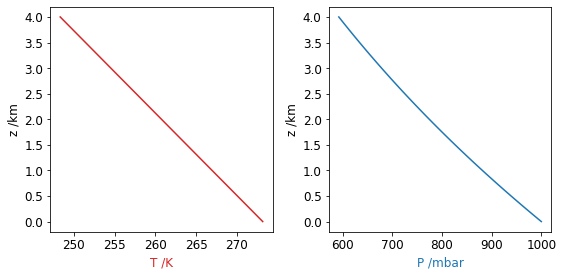

In [4]:

def surroudings_profile(z, tempg, zg, lps_rate):

    profile = 1 - lps_rate/tempg*(z-zg)
    temp_surr = tempg*profile
    p_surr = pg * profile**(g/(rgas_air*lps_rate))

    return temp_surr, p_surr


zplt = np.linspace(zg, zg+w*t_eval[-1], 100)
tempplt, pplt = surroudings_profile(zplt, tempg, zg, lps_rate)
thetaplt = pot_temp(tempplt, pplt, qv0) 

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
axs = axs.flatten()

def axplt(ax,x,y,xlab=None,ylab=None, lab=None, i=0):
    ax.plot(x,y, label=lab, color='C'+str(i))
    ax.set_xlabel(xlab, color='C'+str(i))
    ax.set_ylabel(ylab)

axplt(axs[0], tempplt, zplt/1000, 'T /K', 'z /km', i=3)
axplt(axs[1], pplt/100, zplt/1000,'P /mbar', 'z /km', i=0)

fig.tight_layout()
#plt.close()


In [5]:
class Superdroplets():
    '''Class for all superdroplets, 
    eg. for object drops = Superdroplets(r0) where r0
    is array of drop radii, drops is object with
    radii. multiplicty and other attributes (eg. mass)
    of all superdroplets'''
    
   
    def __init__(self, r, eps, m_sol, mr_sol, ionic):
     
        # Common attributes of all superdroplets
        self.rho = 996.57                                # density of droplets (=density of water at 300K) [Kg/m^3]
       
        # droplet solute properties
        self.m_sol = m_sol                               # mass of solute dissovled [g]
        self.mr_sol = mr_sol                             # Mr of solute [g/mol]
        self.ionic = ionic                               # degree ionic dissociation (van't Hoff factor)

        # attributes unique to each sperdroplet object
        self.eps = eps                                   # array of multiplicity of droplets
        self.r = r                                       # array of droplet radii
        self.r0 = r                                      # array of droplet radii
        self.m0 = self.rho*4/3*np.pi*(self.r0)**3        # initial droplet masses (assuming solute mass negligible)

    @property
    def m(self):
        
        return self.rho*4/3*np.pi*(self.r)**3            # droplet masses (assuming solute mass negligible)
    
    @property
    def m_water(self):
        
        mass_tot = self.rho*4/3*np.pi*(self.r)**3
        
        return mass_tot - self.m0                        # droplet added/lost water mass
        
    @property
    def vol(self):
        return 4/3*np.pi*(self.r)**3                     # droplet volume
    

In [6]:
def lnnormal_dist(r, n_a, mu, sig):
    ''' return number concentration (n [m^-3])
    of particles with radius r in bin of unit length 
    on logarithmic scale based on monomodal 
    lognormal distribution. ie. No particles per cm"^-3
    in bin at radius r of width delta(lnr), n =
    dn_dlnr * delta(lnr)'''
    
    sigtilda = np.log(sig)
    mutilda = np.log(mu)
    norm = n_a/(np.sqrt(2*np.pi)*sigtilda)
    exponent = -(np.log(r)-mutilda)**2/(2*sigtilda**2)
    
    dn_dlnr = norm*np.exp(exponent)                                 # eq.5.8 [lohmann intro 2 clouds]

    return dn_dlnr


def get_lnr_dist(rs, nbins, n_a, mu, sig):
    ''' returns 'nbins' no. of samples from 
    lognormal distribution with even spacing
    in lnr space between ln(r[0]) and ln(rs[1])'''
    
    edgs = np.linspace(np.log(rs[0]), np.log(rs[1]), nbins)          # edges to lnr bins
    wdths = edgs[1:]- edgs[:-1]                                      # lnr bin widths
    lnr = (edgs[1:]+edgs[:-1])/2                                     # lnr bin centres
    lnnorm = lnnormal_dist(np.e**lnr, n_a, mu, sig)                  # lognormal values
    
    return lnr, lnnorm, wdths, edgs



def plot_lognormal(ndrops, lnr, lnnorm, wdths, edgs, pltref=True):
    ''' plots lognormal distribution * bin widths = 
    no. concentration of particles with given radius '''
        
    fig, ax = plt.subplots()
    
    ax.bar(lnr+np.log(1e6), ndrops, wdths, label='samples')
    
    ax1 = ax.twiny()
    linear_wdths = np.e**edgs[1:] - np.e**edgs[:-1]
    ax1.bar(np.e**lnr*1e6, ndrops, linear_wdths*1e6, alpha=0)
    ax1.set_xscale('log')
    
    ax.set_xlabel('ln(r /\u03BCm)')
    ax.set_ylabel('No. concentration of droplets [m$^{-3}$]')
    ax1.set_xlabel('radius, r /\u03BCm)')
    
    if pltref:
        # plot x100 more bins lognormal for reference
        pltlnr, pltnorm, pltwdths = get_lnr_dist(rspan, 
                                nbins*100, n_a, mu, sig)[0:3]
        ax.plot(pltlnr+np.log(1e6), pltnorm*pltwdths*100, 
                    color='k', label='lognormal distribution')
    
    ax.legend()


In [7]:
### ODE solver functions

def dtemp_adiabat(z, temp, p, qv, dz, temp_surr):
    ''' calculate dT/dt for adiabatic process
    of moist parcel (ignoring liquid water 
    content) via dT/dt = dz/dt * dT/dz = dz/dt * dT/dp * dp/dz.
    NOTE! assumes instanataneous volume change 
    of parcel to match pressure with that of 
    surrounding. Also assumes surroundings are dry and
    in hydrostatic equilibrium '''
    
    gamma = rgas_moist(qv)/cp_moist(qv)            # moist parcel constants
    dp_dz_p = -g/(rgas_air*temp_surr)              # 1/p_surr * dp/dz       
    dtemp = dz*gamma*temp*dp_dz_p                  # dT/dt = dz * (p * dT/dp) * (1/p_surr * dp/dz)
   
    # (redundant but useful) pressure evolution
    dp = w * dp_dz_p * p      
        
    return dtemp, dp


def diffusion_growth(drops, temp, p, qv):
    ''' diffusion growth of droplets by condensation
    given temperature, pressure and qv.
    NOTE! shrinking by evaporation not included, nor
    are ventillation effects fv(r) (see Seifert & stevens 2010)'''
    
    r = drops.r
    
    # supersaturation of parcel
    psat = saturation_pressure(temp)
    pv = qv*p/(mr_ratio + qv)                       
    qsat = mr_ratio * psat/(p-pv) 
    s = qv/qsat - 1                                
    
    if s > 0: 
        # some factors in diffusional growth equation
        thermk = 4.1868e-3 * (5.69 + 0.017*(temp-273.15))             # [eq.7.24 lohmann intro 2 clouds]
        diffuse_v = 2.11e-5 * (temp/273.15)**1.94 * (101325/p)        # [eq.7.26 lohmann intro 2 clouds]
        fkl = (latent_v/(rgas_v*temp) -1)*latent_v/(thermk*temp)
        fdl = rgas_v*temp/(diffuse_v*psat)
        
        # curvature and mass dissolved solute effects
        a = 3.3e-7/temp                                               # [eq.6.24]
        b = 43e-6*drops.m_sol*drops.ionic/drops.mr_sol                # [eq.6.22]
        
        # radial growth of droplets
        #dr = s/(rho_l * (fkl+fdl) *r)                                
        dr = (s -a/r +b/r**3) / (rho_l * (fkl+fdl) *r)                #[eq.7.27 lohmann intro 2 clouds]

        # resultant change to temp, qv and qc of parcel
        dm = drops.rho*4*np.pi*(drops.r**2)*dr                        # mass of water condsed onto each drop
        tot_drhov = np.sum(dm*drops.eps)                              # change in density of water in volume
        dqc = tot_drhov/moist_rho(temp, p, qv)
        dqv = -dqc
        dtemp_c = -latent_v/cp_moist(qv) * dqv
    
    else:
        dr = np.zeros(len(r))
        dtemp_c, dqv, dqc = 0, 0, 0
        
    
    return dr, dtemp_c, dqv, dqc


def rising_parcel(t, y, w, tempg, zg, 
                lps_rate, drops, cond=True):
    ''' differential equations for rising parcel 
    (thermo)dynamics with condensation onto droplets
    if supersaturation > 0.
    Parcel rises, expands adiabatically and then
    condenses water if qv > q_sat. Rate of condensation
    determined by growth rate of droplets (supersaturation
    is possible if growth to slow to compensate rise
    in relative humidity)'''
    
    z, temp, p, qv, qc = y[:5]
    r = y[5:]
    
    drops.r = r
    
    ### dynamics of parcel
    #tau = 50*60                     # tau_w = 50min
    #dz = w*np.sin(2*np.pi*t/tau)
    dz = w
    
    ### thermodynamics of parcel
    # adiabatic expansion
    temp_surr, p_surr = surroudings_profile(z, tempg, zg, lps_rate)
    dtemp, dp = dtemp_adiabat(z, temp, p, qv, dz, temp_surr)
    
    # condensation (by diffusional growth of droplets)
    if cond:
        dr, dtemp_c, dqv, dqc = diffusion_growth(drops, 
                                temp, p, qv)
    else:
        dr = np.zeros(len(drops.r))
        dtemp_c, dqv, dqc = 0, 0, 0

    
    dtemp+=dtemp_c
    dy = [dz, dtemp, dp, dqv, dqc]
    dy.extend(list(dr))
    
    return dy

Initial Droplet Distribution:



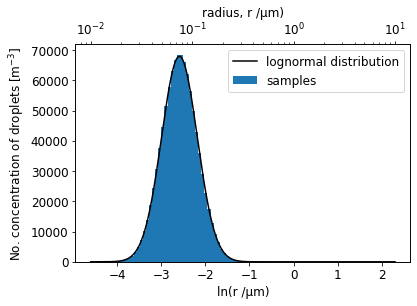

In [8]:
### ODE solution

# initialise droplets
lnr, lnnorm, wdths, edgs = get_lnr_dist(rspan, nbins, n_a, mu, sig)
r0 = np.e**lnr
eps = [int(n) for n in lnnorm*wdths]

print('Initial Droplet Distribution:\n')
plot_lognormal(eps, lnr, lnnorm, wdths, edgs)



drops = Superdroplets(r0, eps, m_sol, mr_sol, ionic)        # drops = object of all droplets in parcel
args = [w, tempg, zg, lps_rate, drops, cond]
y0 = [z0, temp0, p0, qv0, qc0]
y0.extend(list(drops.r))
sol = solve_ivp(rising_parcel, tspan, 
                y0, method='LSODA', t_eval=t_eval, args=args,
                   max_step=maxtstep)     

In [9]:
### ODE solution data
time = sol.t
z, temp, p, qv, qc = sol.y[:5]
r = sol.y[5:]
print('shapes sanity check')
print(z.shape, temp.shape, p.shape)
print(qv.shape, qc.shape, r.shape)

### some other useful thermodynamic variables
theta = pot_temp(temp, p, qv)                                            # parcel potential temp (theta)
temp_surr, p_surr = surroudings_profile(z, tempg, zg, lps_rate)          # surrounding temp, p
dry_adia = temp0*(p/p0)**(rgas_dry/cp_dry)                               # parcel T if followed dry adiabat 
dry_adia_theta = dry_adia*(p0/p)**(rgas_dry/cp_dry)                      # parcel theta if followed " " (const.)
pv = qv*p/(mr_ratio + qv)                                                # partial vapour pressure
psat = saturation_pressure(temp)
relh = pv/psat                                                           # relative humidity
qsat = mr_ratio * psat/(p-pv) 
s = qv/qsat - 1                                                          # supersaturation

shapes sanity check
(1000,) (1000,) (1000,)
(1000,) (1000,) (99, 1000)


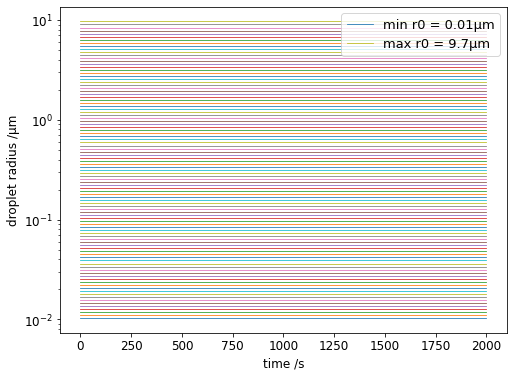

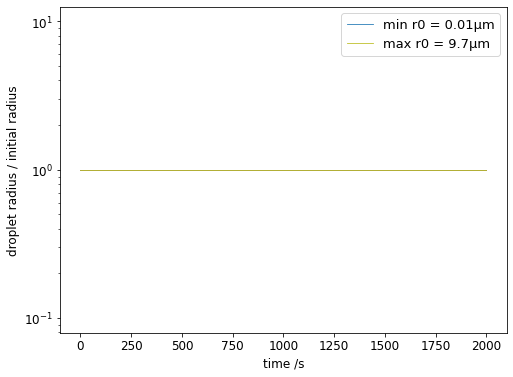

In [10]:
### plots of droplet radii growth
fig, ax = plt.subplots(figsize=(8,6))
labs = ['{:.2g}\u03BCm'.format(r*1e6) for r in drops.r0]
for i in range(len(r)):
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == len(r)-1:
        label = 'max r0 = '+labs[i]
    ax.plot(time, r[i]*1e6, linewidth=0.8, label=label)
ax.set_xlabel('time /s')
ax.set_ylabel('droplet radius /\u03BCm')
ax.set_yscale('log')
ax.legend(fontsize=13)

fig, ax = plt.subplots(figsize=(8,6))
#cols = ['b','g','r','c','m','y','k']
labs = ['{:.2g}\u03BCm'.format(r*1e6) for r in r0]
labs2 = [None]*len(r0)
for i in range(len(r)):    
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == len(r)-1:
        label = 'max r0 = '+labs[i]
    ax.plot(time, r[i]/r[i,0], linewidth=0.8, label=label) #,color=cols[i])
ax.set_xlabel('time /s')
ax.set_ylabel('droplet radius / initial radius')
ax.set_yscale('log')
ax.legend(fontsize=13)

--- Base of cloud at 380.38m ---
-- Max supersat at 4000.00m --


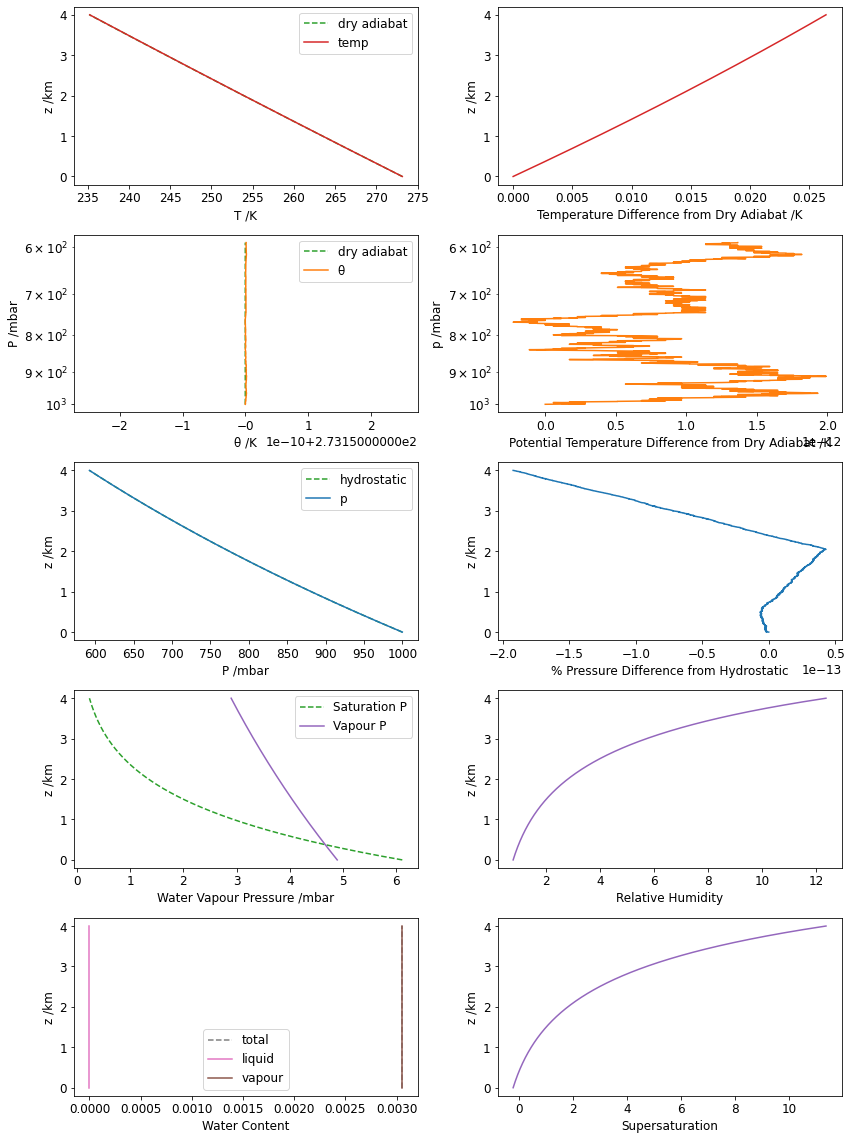

In [11]:
### plots of z, Temp, theta and pressure profiles

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12,16))
axs = axs.flatten()

def axplt(ax, x, y, xlab=None, ylab=None, lab=None, c=0, l='-'):
    ax.plot(x,y, label=lab, color='C'+str(c), linestyle=l)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

axplt(axs[0], dry_adia, z/1000, lab='dry adiabat', c=2, l='--')
axplt(axs[4], p_surr/100, z/1000, lab='hydrostatic', c=2, l='--')
axplt(axs[2], dry_adia_theta, p/100, lab='dry adiabat', c=2, l='--')
axplt(axs[0], temp, z/1000, 'T /K', 'z /km', 'temp', 3)
axplt(axs[4], p/100,z/1000,'P /mbar','z /km', 'p', 0)
axplt(axs[2], theta, p/100,'\u03B8 /K','P /mbar', '\u03B8', 1)
axplt(axs[6], psat/100, z/1000,lab='Saturation P', c=2, l='--')
axplt(axs[6], pv/100, z/1000, 'Water Vapour Pressure /mbar','z /km', 'Vapour P', c=4)
axplt(axs[8], qv+qc, z/1000, lab='total', c=7, l='--')
axplt(axs[8], qc, z/1000, lab='liquid', c=6)
axplt(axs[8], qv, z/1000, 'Water Content','z /km', 'vapour', c=5)

axplt(axs[1], temp-dry_adia, z/1000, 'Temperature Difference from Dry Adiabat /K', 'z /km', c=3)
axplt(axs[5], (p-p_surr)/p_surr, z/1000, '% Pressure Difference from Hydrostatic', 'z /km', c=0)
axplt(axs[3], (theta-dry_adia_theta), p/100, 'Potential Temperature Difference from Dry Adiabat /K', 'p /mbar', c=1)
axplt(axs[7], pv/psat, z/1000, 'Relative Humidity' ,'z /km', c=4)
axplt(axs[9], s, z/1000, 'Supersaturation' ,'z /km', c=4)

for ax in axs[::2]:
    ax.legend()
axs[2].set_yscale('log')
axs[2].invert_yaxis()
axs[3].set_yscale('log')
axs[3].invert_yaxis()

ind = np.where(s==s[s>0][0])[0]
print('--- Base of cloud at {:.2f}m ---'.format(z[ind][0]))
print('-- Max supersat at {:.2f}m --'.format(z[np.argmax(s)]))

#for ax in axs:
    #ax.set_ylim([0.4, z[-1]/1000])

#psat = saturation_pressure(temp)
#axplt(axs[3], psat/100, z/1000,'saturation curve /mbar', 'z /km')

fig.tight_layout()
#plt.close()

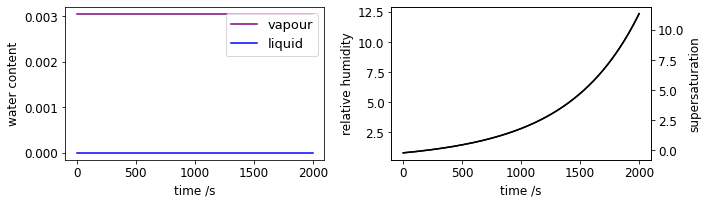

In [12]:
### plots of time evolution of water as parcel rises

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

axs2 = axs[1].twinx()

axs[0].plot(time, qv, color='purple', label='vapour')
axs[0].plot(time, qc, color='blue', label='liquid')
axs[1].plot(time, relh, color='k')
axs2.plot(time, s, color='k')
axs[0].set_xlabel('time /s')
axs[0].set_ylabel('water content')
axs[1].set_xlabel('time /s')
axs[1].set_ylabel('relative humidity')
axs2.set_ylabel('supersaturation')
plt.tight_layout()
axs[0].legend(fontsize=13, loc='upper right')
plt.show()

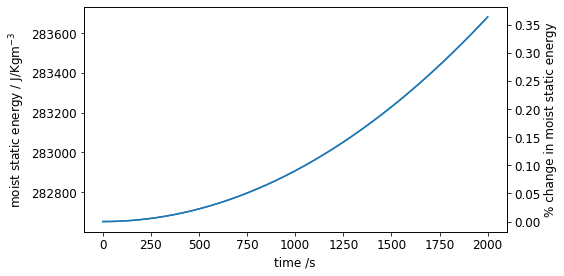

In [13]:
### Moist Static Energy Conservation

def moist_static_energy(z, temp, qv=0, dry=False):
    ''' calculate the moist static energy /m^3
        (not assuming dry air cp) '''
    
    if dry:
        return g*z + cp_moist(qv)*temp
    else:
        return  g*z + latent_v*qv + cp_moist(qv)*temp


mse = moist_static_energy(z, temp, qv)
#dse = moist_static_energy(z, temp, 0)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.plot(time, mse)
ax1 = ax.twinx()
ax1.plot(time, ((mse-mse[0])/mse[0]*100))
ax.set_ylabel('moist static energy / J/Kgm$^{-3}$')
ax1.set_ylabel('% change in moist static energy')
ax.set_xlabel('time /s')

plt.tight_layout()
plt.show()

In [14]:
### plots of changing droplet size distribution


def geometric_mean_stddev(radii, eps):

    mean = (np.prod(radii**eps))**(1/np.sum(eps))
   
    stddev = 0
    
    return mean, stddev




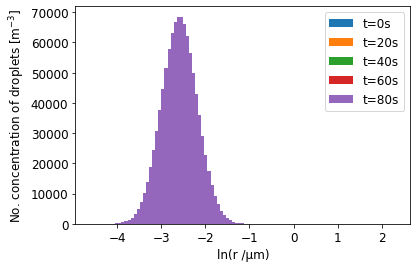

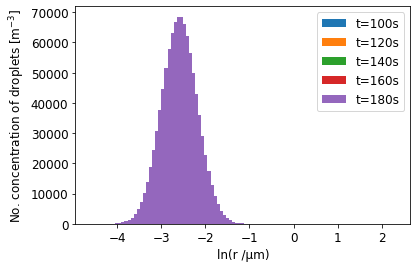

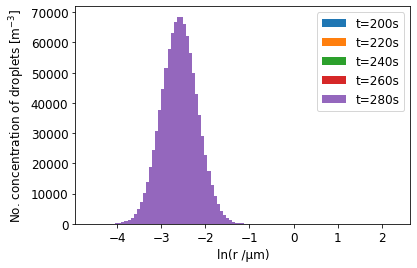

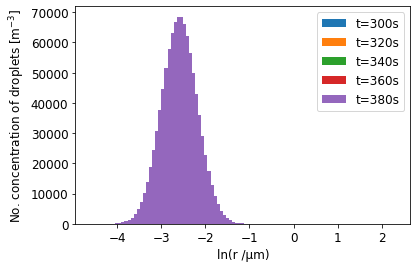

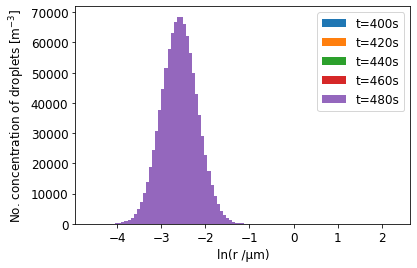

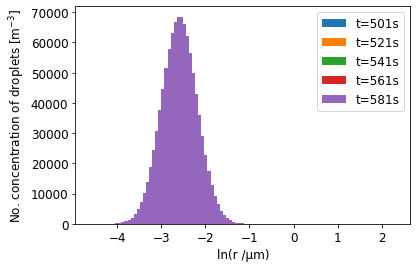

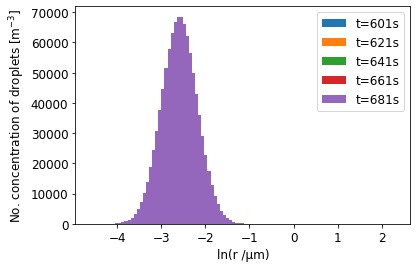

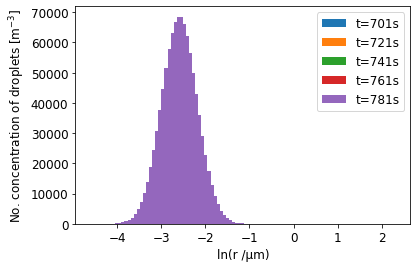

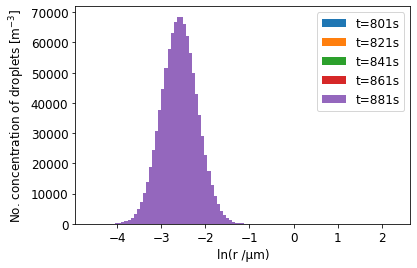

In [15]:
trange = np.arange(0,1000,100)


#def drops2lnrdist(drops, rs, nbins, n_a, mu, sig):
#    ''' convert droplets into lnr distribution'''
#    
#    drop_radii = drops.r0
#    eps = drops.eps
#    
#    edgs = np.linspace(np.log(rs[0]), np.log(rs[1]), nbins)    #edges to lnr bins
#    wdths = edgs[1:]- edgs[:-1]
#    lnr = (edgs[1:]+edgs[:-1])/2
#    
#    print(edgs)
#    dist = []
#    for b in range(len(lnr)):
#        print(np.where(drop_radii < lnr))
#    
#    #lnnorm = lnnormal_dist(np.e**lnr, n_a, mu, sig) 
#    
#    return lnr, lnnorm, wdths, edgs
#
##drops2lnrdist(drops, rspan, nbins, n_a, mu, sig)

for i in range(len(trange)-1):
    i1 = np.argmin(abs(time-trange[i]))
    i2 = np.argmin(abs(time-trange[i+1]))
    subset = time[i1:i2:10]
    fig, ax = plt.subplots()
    for t in subset:
        
        ind = np.argmin(abs(time-t))
        t = time[ind]
        radii = r[:,ind]
        eps = drops.eps
        
        ax.bar(np.log(radii)+np.log(1e6), eps, wdths[0], label='t={:.0f}s'.format(t))
        #ax.plot(np.log(radii)+np.log(1e6), eps, color='k')
    
        #ax1 = ax.twiny()
        
        #ax1.bar(radii*1e6, eps, linear_wdths*1e6, alpha=0)
        #ax1.set_xscale('log')
        
        ax.set_xlabel('ln(r /\u03BCm)')
        ax.set_ylabel('No. concentration of droplets [m$^{-3}$]')
        #ax1.set_xlabel('radius, r /\u03BCm)')
        

        ax.legend()
        
    plt.show()